Mounting Drive to access data

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive' , force_remount = True)
  intra_annotated_file = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/combined_annotated.csv"
  AE_features = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/AE_features.csv"
  encoder_save = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/encoder_model.keras"
  decoder_save = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/decoder_model.keras"
else:
  from imported_files.paths_n_vars import filtered_merged ,AE_features, encoder_save, decoder_save

#### Import TensorFlow and other libraries


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# %pip install tensorflow --quiet
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras.models import load_model


Num GPUs Available:  0


User defined functions

In [4]:
def plot_signal(x : list|range ,y : list , x_label = "" , y_label = "" , title = ""):
    plt.grid(True)
    plt.plot(x,y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.close()

def MyMinMaxScaler(dataframe : pd.DataFrame):
    '''
    Scales each PPG segment individually
    Function assumes the PPG segments are present column wise in the given DataFrame
    '''
    return (dataframe - dataframe.min())/(dataframe.max() - dataframe.min())

def MyZScoreScaler(dataframe : pd.DataFrame):
    '''
    Scales each PPG segment individually
    Function assumes the PPG segments are present column wise in the given DataFrame
    '''
    return (dataframe - dataframe.mean())/(dataframe.std())

#### Load the trained encoder and decoders

In [5]:
encoder = load_model(encoder_save)
decoder = load_model(decoder_save)

# Show the model architecture
encoder.summary()
decoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1250)              0         
                                                                 
 Encoder3 (Dense)            (None, 100)               125100    
                                                                 
Total params: 125100 (488.67 KB)
Trainable params: 125100 (488.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder3 (Dense)            (None, 1250)              126250    
                                                                 
Total params: 126250 (493.16 KB)
Trainable params: 126250 (493.16 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

##### Load the raw segments, normalize them and extract the features

           0_1       0_2       0_3       0_4       0_5       0_6       0_7  \
1    -0.042070 -0.040675 -0.022270 -0.026176 -0.033072  0.002050 -0.080611   
2    -0.044036 -0.053669 -0.029984 -0.026946 -0.036278  0.039917 -0.083740   
3    -0.046039 -0.066687 -0.038088 -0.027939 -0.039516  0.077239 -0.086731   
4    -0.048063 -0.079748 -0.046565 -0.029386 -0.042834  0.113421 -0.089621   
5    -0.050088 -0.092867 -0.055380 -0.031499 -0.046284  0.147895 -0.092451   
...        ...       ...       ...       ...       ...       ...       ...   
1246  0.063994 -0.033831  0.197038 -0.010533  0.203789  0.015806  0.224720   
1247  0.058181 -0.031961  0.180877 -0.010761  0.188695  0.014135  0.207741   
1248  0.053267 -0.029864  0.164966 -0.010810  0.172458  0.012498  0.189820   
1249  0.049115 -0.027592  0.149464 -0.010687  0.155501  0.010922  0.171364   
1250  0.045584 -0.025200  0.134502 -0.010400  0.138239  0.009433  0.152768   

           0_8       0_9      0_10  ...     12_19     12_20    

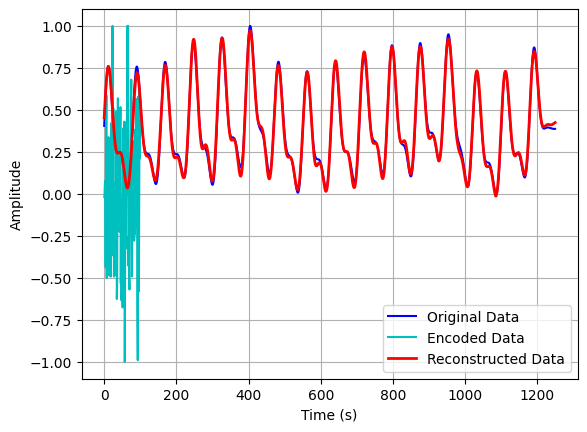

In [6]:
# raw_segments = (pd.read_csv(intra_annotated_file ).iloc[1 : , ])
# from imported_files.merge import merge_csv
# merged_new_anno = merge_csv(new_annotation_folder , merge_path = new_annotation_folder+"/merged.csv")
# print(merged_new_anno.shape)
raw_segments = (pd.read_csv(filtered_merged)).iloc[1 : , ]
print(raw_segments)
scaled_data = MyMinMaxScaler(raw_segments).values.T # mind the Transpose operation


# extract AE features
ae_features = encoder(scaled_data).numpy()
print(ae_features.shape)

# Plot original , reconstructed and encoded signals 
segment = (ae_features)[9]
print(segment.shape)
reconstructed_seg = decoder(tf.reshape(segment , [-1,ae_features.shape[1]])).numpy().reshape(1250,-1)
print(len(reconstructed_seg))
print(reconstructed_seg)
plt.figure()
plt.plot(range(len(scaled_data[9,:]) ), scaled_data[9,:], 'b-', label='Original Data')
plt.plot(range(len(segment) ), segment, 'c-', label='Encoded Data')
plt.plot(range(len(reconstructed_seg) ), reconstructed_seg, 'r-', linewidth = 2, label='Reconstructed Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# save the features
ae_features_df = pd.DataFrame(data = ae_features , columns = [f'AE_{i}' for i in range(ae_features.shape[1])])
ae_features_df.to_csv(AE_features ,index=False)